In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
%matplotlib notebook

In [3]:
s3login = '/home/jupyter-ubuntu/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

#s3.ls('uwaoceanprocesses-suntans/SUNTANS_125m')

In [4]:
s3.ls('uwaoceanprocesses-suntans/')

['uwaoceanprocesses-suntans/.zattrs',
 'uwaoceanprocesses-suntans/.zgroup',
 'uwaoceanprocesses-suntans/.zmetadata',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr',
 'uwaoceanprocesses-suntans/NWS_SSH_BC_20132014.zarr',
 'uwaoceanprocesses-suntans/NWS_SSH_BC_20132014_tchunk_v2.zarr',
 'uwaoceanprocesses-suntans/SUNTANS_125m']

In [5]:
f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr/", s3=s3)
varname = 'eta_steric'
units = 'cm'
scale = 100

f2 = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr/", s3=s3)
# varname = 'uc'
# units = 'cm s$^{-1}$'
# scale = 100
varname = 'eta'
units = 'cm'
scale = 100

# varname = 'temp'
# units = 'degC'
# scale = 1.

ds = xr.open_dataset(f, engine='zarr')
ds2 = xr.open_dataset(f2, engine='zarr')

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds2

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, Nk: 80, time: 8772, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    eta      (time, Nc) float64 ...
    nfaces   (Nc) int32 ...
    temp     (time, Nc) float64 ...
    uc       (time, Nc) float64 ...
    vc       (time, Nc) float64 ...
    xp       (Np) float64 ...
    xv       (Nc) float64 ...
    yp       (Np) float64 ...
    yv       (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [6]:
ds.time

<xarray.DataArray 'time' (time: 8772)>
array(['2013-07-01T00:01:00.000000000', '2013-07-01T01:00:00.000000000',
       '2013-07-01T02:00:00.000000000', ..., '2014-06-30T22:00:00.000000000',
       '2014-06-30T23:00:00.000000000', '2014-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
Attributes:
    long_name:  time

In [7]:
def extract_point(xpt, ypt):
    dist = np.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = np.argwhere(dist==dist.min())[0,0]

    return xr.merge([ds.isel(Nc=idx), ds2.isel(Nc=idx)], compat='override').drop_vars(['xp','yp','cells'])


In [8]:
#3 points for 15 km: x = [123.1043, 122.8718, 123.0239]; y = [-13.9622,-14.0036,-14.1842].
#3 points for 20 km: x = [123.1391, 122.8290, 123.0319]; y = [-13.9329,-13.9881,-14.2290].

myds = xr.concat([extract_point( 123.1391, -13.9329),
                  extract_point( 122.8290, -13.9881),
                  extract_point( 123.0319, -14.2290),

                 ], dim='Nc')
myds

<xarray.Dataset>
Dimensions:     (Nc: 3, time: 8772, Nk: 80)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r         (Nk) float64 4.112 12.71 21.69 ... 5.475e+03 5.73e+03 5.996e+03
Dimensions without coordinates: Nc, Nk
Data variables:
    dv          (Nc) float64 265.0 333.1 245.1
    eta_steric  (Nc, time) float64 0.0 0.0002991 0.00125 ... 0.1315 0.1284
    nfaces      (Nc) int32 7 6 6
    xv          (Nc) float64 123.1 122.8 123.0
    yv          (Nc) float64 -13.93 -13.99 -14.22
    dz          (Nc, Nk) float64 8.224 8.594 8.981 9.385 ... 243.8 254.8 266.2
    eta         (Nc, time) float64 0.0 0.04594 0.1136 ... -1.255 -1.248 -0.8851
    temp        (Nc, time) float64 28.69 28.63 28.56 28.52 ... 27.44 27.4 27.4
    uc          (Nc, time) float64 0.0 0.006151 0.01498 ... -0.01673 0.1451
    vc          (Nc, time) float64 0.0 -0.003567 0.0007055 ... 0.1047 -0.0545
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

In [99]:
myds.to_netcdf('../DATA/SUNTANS_2km_2013_2014_SWOT_20km_moorings.nc')

In [100]:
xr.open_dataset('../DATA/SUNTANS_2km_2013_2014_SWOT_20km_moorings.nc')

<xarray.Dataset>
Dimensions:     (Nc: 3, time: 8772, Nk: 80)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r         (Nk) float64 ...
Dimensions without coordinates: Nc, Nk
Data variables:
    dv          (Nc) float64 ...
    eta_steric  (Nc, time) float64 ...
    nfaces      (Nc) int32 ...
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    dz          (Nc, Nk) float64 ...
    eta         (Nc, time) float64 ...
    temp        (Nc, time) float64 ...
    uc          (Nc, time) float64 ...
    vc          (Nc, time) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

<IPython.core.display.Javascript object>


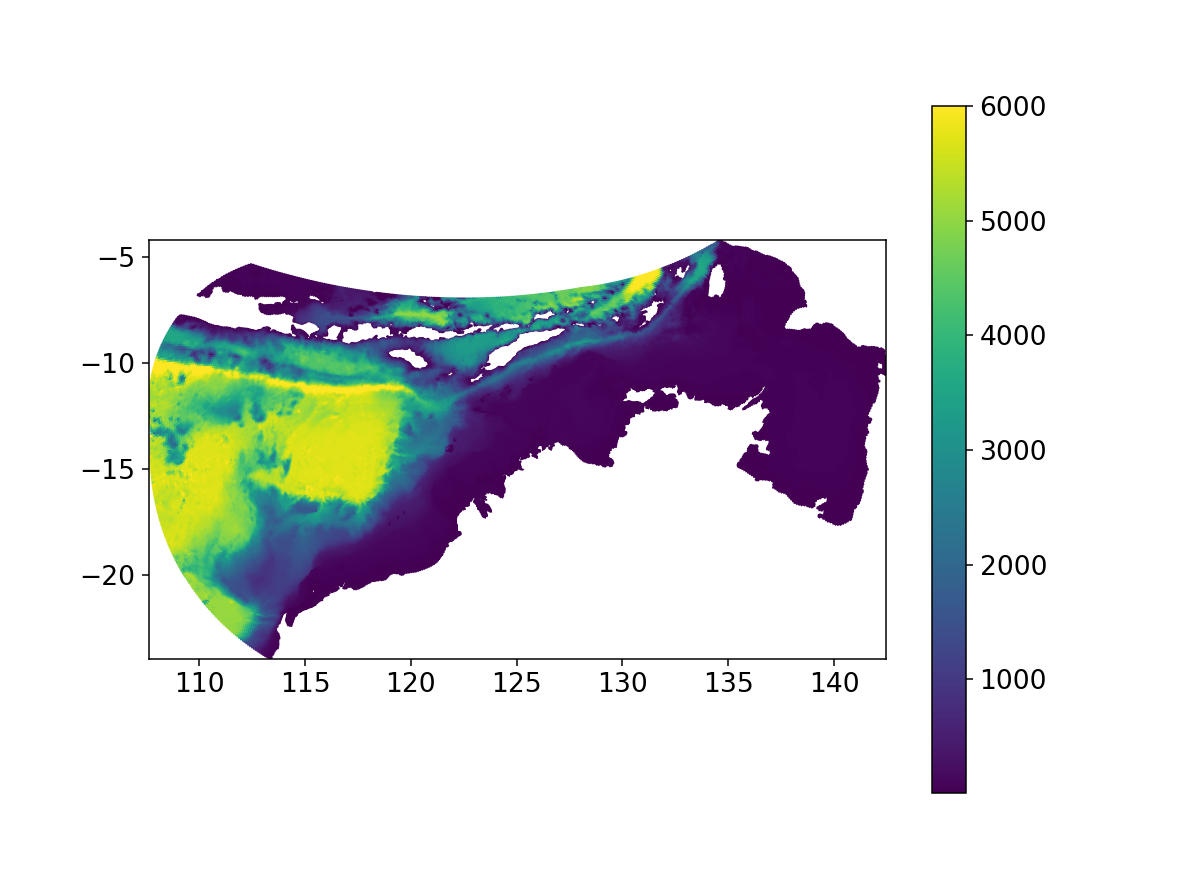

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f5d3e8c94e0>)

In [13]:
ds.suntans.plotcelldata(ds.dv)

In [14]:
ds.suntans.interpolate?

<IPython.core.display.Javascript object>


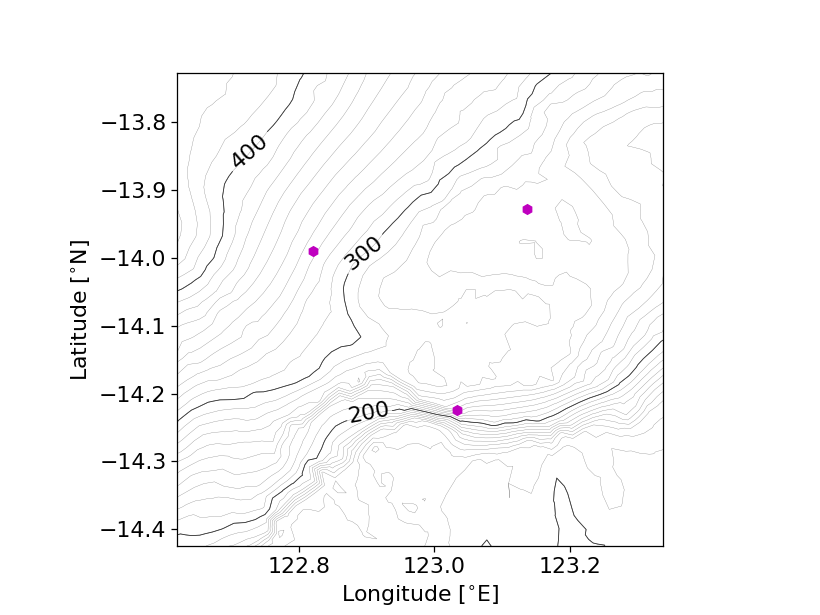

In [98]:
# Plot a map of the sites

plt.figure()
ax=plt.subplot(111)
#ds.suntans.plotcelldata(ds.dv, [100,200,300], cmap=cm.deep, vmin=100, vmax=400)
_,_,C,_ = ds.suntans.contourf(ds.dv, [100,200,300,400,500], filled=False, colors='k', linewidths=0.5)
_,_,_,_ = ds.suntans.contourf(ds.dv, np.arange(100,500,10), filled=False, colors='0.5', linewidths=0.2)

plt.plot(myds.xv, myds.yv,'mh')
# for xx, yy, zz in zip(myds.xv.values, myds.yv.values, myds.dv.values):
#     plt.text(xx, yy, '{:3.0f} m'.format(zz),'mh')

ax.set_ylim(myds.yv.min()-0.2, myds.yv.max()+0.2)
ax.set_xlim(myds.xv.min()-0.2, myds.xv.max()+0.2)
ax.set_aspect('equal')

ax.axes.clabel(C, manual=[(122.9,-14.2),(122.9,-14.0),(122.7,-13.8)] )
plt.ylabel('Latitude [$^{\circ}$N]')
plt.xlabel('Longitude [$^{\circ}$E]')

plt.savefig('../DATA/BathyMap_20km_mooring.png',dpi=150)

In [93]:
ax.axes.clabel?

In [71]:
ds.suntans.contourf(ds.dv, [100,200,300,400], filled=False, colors='k', linewidths=0.5)


(<Figure size 819.623x614.717 with 1 Axes>,
 <AxesSubplot:>,
 None)

In [58]:
#
from scipy import spatial
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values
pts = np.vstack([ds.suntans.xv,ds.suntans.yv]).T
#spatial.Delaunay(pts)
np.any(np.isnan(pts).T)
ds.suntans.build_tri_voronoi()

<IPython.core.display.Javascript object>


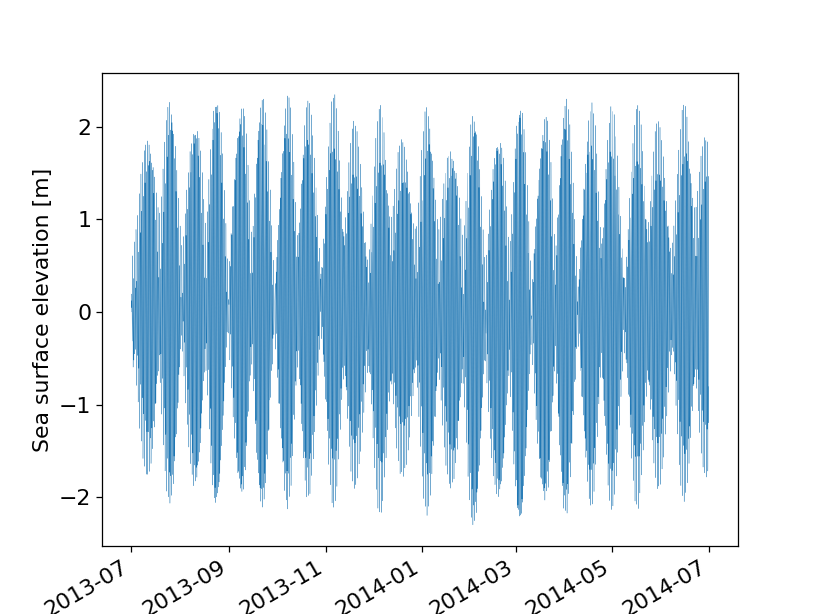

In [23]:
plt.figure()
myds[varname].plot(lw=0.2)

In [24]:
from scipy import signal


In [25]:
# Calculate the Coriolis frequency
lat = ypt
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_cpd = np.abs(f_coriolis*86400/(2*np.pi))
f_cpd, f_coriolis

(0.48157080235996635, -3.5020817011051213e-05)

4096 (8772,)
Length of each segment [days]:  170.66666666666666
4096 (8772,) 0.005859375 0.005859375
10162.812996845245 10424.624138753392 0.9748853159189819


<IPython.core.display.Javascript object>


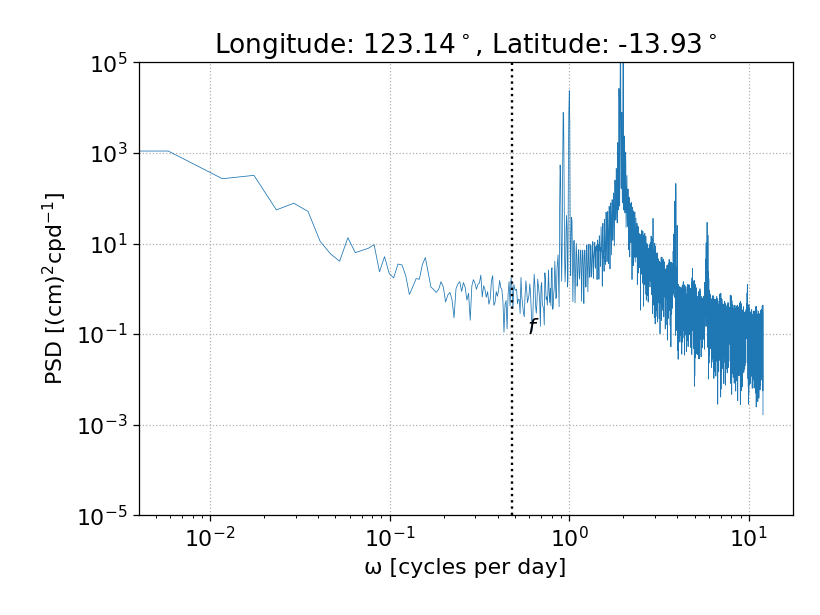

In [28]:
# Compute the power spectrum of the signal
u = myds[varname]
time = u.time.values
nperseg = 2**12


# dt = (time[1]-time[0]).astype('float')/1e9
dt = 3600.
dt_days = dt/86400

y = u.values * scale
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

print(nperseg, y.shape)
print('Length of each segment [days]: ', nperseg*dt/86400)

# Check the scaling by comparing the signal variance to the integral under the power spectrum
df = f[1] - f[0]
print(nperseg, y.shape, df, np.mean(np.diff(f)))
print(np.var(y-y.mean()), np.trapz(Puu, dx=df), np.var(y)/np.trapz(Puu, dx=df))


plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu, lw=0.5)

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [('+units+')$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-5, 1e5)
ax.axvline(f_cpd, c='k', ls=':')
ax.text(f_cpd+0.1, 1e-1, '$f$')
plt.title('Longitude: {:3.2f}$^\circ$, Latitude: {:3.2f}$^\circ$'.format(xpt,ypt))
plt.tight_layout()

# \n Water Depth: {:3.1f} m total_depth

In [15]:
dt

3540.0